# Multi-period (Lifecycle) model

### Setup
There is a unit mass of households. They enter the economy at age 20 ($j=1$) without asset, supply one unit of labor exogenously until age 65 ($j=J_R=46$), which gives them $w$ unit of income, and they die at age 80 $(j=J=61)$. They derive utility from consumption ($c_j$) every period, and they discount future by $\beta$. The asset ($a_j$) earns an interest with rate $r$. They are not allowed to borrow (i.e., $a_{j+1}\ge 0$). The problem reads as follows:

\begin{align*}
    & \max_{\{c_j\}_{j=1}^J} \sum_{j=1}^J \beta^{j-1} u(c_j)\\
    \text{s.t.} & \\
    c_j &= 
    \begin{cases}
        w + (1+r)a_j - a_{j+1} & \text{if}~~~j\le J_R\\
        (1+r)a_j - a_{j+1} & \text{if}~~~j\in\{J_R+1,...,J-1\}\\
        (1+r)a_j & \text{if}~~~j=J\\
    \end{cases}\\
    & a_1=0, ~~a_{j+1} \ge 0~~~\forall j
\end{align*}

If we want to solve it analytically, we have to solve $J-1(=60)$ equations (first-order conditions):
$$
u'(c_j) = (1+r)\beta u'(c_{j+1})~~~\forall j=1,...,J-1
$$

How do we solve the problem computationally? We solve it $\textit{backward}$, given that we know that at the end of their life, they consume everything (i.e., $c_J=(1+r)a_{J}$). 

Recursive formulation is useful for understanding and implementing this computational algorithm. Here, the state variables are age $j$ and current asset holdings $a$, with $a'$ representing next period's asset holdings. The value function is given as follows:

\begin{align*}
    V(a,j) = & \max_{a'\ge 0} u(c) + \beta \left\{
    \begin{array}{rr}
    V(a',j+1) & \text{if} \ j < J\\
    0         & \text{if} \ j = J
    \end{array}
    \right. \\
    \text{s.t.} & \\
    c &= 
    \begin{cases}
        w + (1+r)a - a' & \text{if}~~~j\le J_R\\
        (1+r)a - a' & \text{if}~~~j\in\{J_R,...,J-1\}\\
        (1+r)a & \text{if}~~~j=J\\
    \end{cases}
\end{align*}

We know that, at the end of life (i.e., age $j=J$), the value function is given as:

$$
V(a,J) = u((1+r)a)
$$

Given the value function at the final period, the value function at age $J-1$ is given by:

$$
V(a,J-1) = \max_{a'\ge0} \left\{u((1+r)a - a') + \beta V(a',J)\right\}
$$

We can solve this problem by, for example, grid search method: given $a\in\mathcal{A}$, where $\mathcal{A}$ is the discretized asset space, we search for the optimal $a'$ that solves this value function. Once we obtain the value function $V(a,J-1)$, we can proceed similarly for age $J-2$, and so on. This procedure—solving the problem recursively from the final period backward—is known as $\textit{backward induction}$.

In [2]:
using Plots

# parameters
β=0.98
r=0.02
w=1.0

# discretization
mina = 1.e-5
maxa = 10.0
na   = 1000
grida = collect(LinRange(mina,maxa,na));

J=61
JR=46

V = zeros(na,J);
Va = zeros(na);
apol_arg = zeros(Int,na,J); # policy function for saving
apol = zeros(na,J); # policy function for saving
cpol = zeros(na,J)

penalty=-1.e+8

for jc in J:-1:1 # solve backward
    acc_start=1
    for ac in 1:na
        if (jc==J)
            c = (1.0+r)*grida[ac]
            if (c>0)
                V[ac,jc]=log(c)
            else
                V[ac,jc]=penalty
            end
            cpol[ac,jc]=c;
        elseif (JR < jc) && (jc < J)
            Va.=penalty;
            for acc in acc_start:na
                c = (1.0+r)*grida[ac]-grida[acc]
                if (c>0)
                    Va[acc] = log(c) + β*V[acc,jc+1]
                else
                    Va[acc] = penalty
                end
            end
            arg = argmax(Va)
            acc_start = arg
            apol_arg[ac,jc]=arg
            apol[ac,jc] = grida[arg]
            V[ac,jc] = Va[arg]
            cpol[ac,jc]=(1.0+r)*grida[ac]-grida[arg];
        else
            Va.=penalty;
            for acc in acc_start:na
                c = w+(1.0+r)*grida[ac]-grida[acc]
                if (c>0)
                    Va[acc] = log(c) + β*V[acc,jc+1]
                else
                    Va[acc] = penalty
                end
            end
            arg = argmax(Va)
            acc_start = arg
            apol_arg[ac,jc]=arg
            apol[ac,jc] = grida[arg]
            V[ac,jc] = Va[arg]
            cpol[ac,jc]=w + (1.0+r)*grida[ac]-grida[arg];
        end
    end
end

# find asset profile
aj = zeros(J);
aj[1]=grida[1];
a_arg = zeros(Int,J);
a_arg[1]=1;
arg_yesterday=1;
for jc in 2:J
    arg = apol_arg[arg_yesterday,jc-1];
    aj[jc]=grida[arg];
    a_arg[jc]=arg;
    arg_yesterday=arg;
end

# find consumption
cj = zeros(J);
for jc in 1:J
    arg = a_arg[jc];
    cj[jc]=cpol[arg,jc]
end

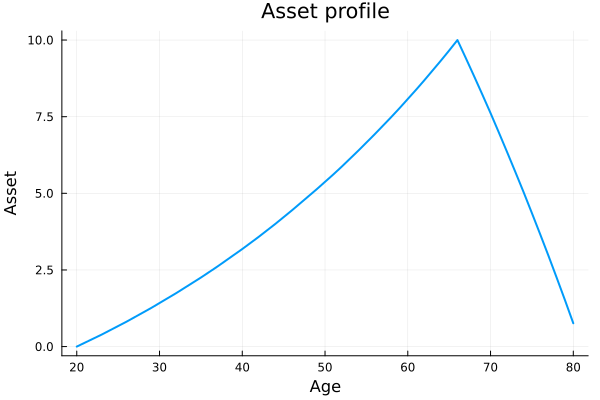

In [3]:
## plot asset profile
plot(20:20+J-1, aj,
    xlabel="Age",
    ylabel="Asset",
    title="Asset profile",
    lw=2,
    label="")

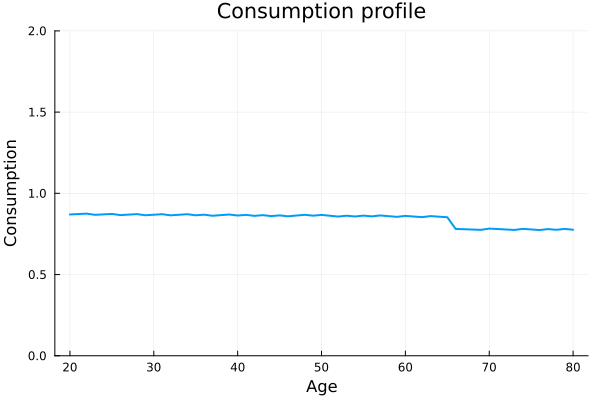

In [ ]:
## plot consumption profile
plot(20:20+J-1, cj, 
     xlabel="Age", 
     ylabel="Consumption", 
     title="Consumption profile", 
     lw=2, 
     label="", 
     ylim=(0, 2))

## Exercise
1. Construct a function that solves the model, taking key (deep) parameters as inputs.
2. Solve the model and plot the results for different values of parameters (e..g, compare asset and consumption profiles under $\beta=0.98$ vs. $\beta=0.90$).